# Лабораторная работа №3
Пресняцкий Виктор, гр. 956241, вариант 5

## Аппроксимация функции с помощью двухслойной нейронной сети

#### Дана функция y = f(t). Необходимо аппроксимировать данную функцию по вектору значений y для t = t0 : 0.1 : t1.

#### f(t) = (2.5t + 1.7) * sin(1.1t + 0.7); t=[-10,10]

In [3]:
import numpy as np
import math
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [4]:
t_interval = (-10, 10, 0.1)


def f(t):
    return (2.5 * t + 1.7) * math.sin(1.1 * t + 0.7)


def generate_dataset(interval):
    X = np.arange(*interval)
    y = np.array([f(x) for x in X]).astype(np.float)
    X = X.reshape(X.size, 1)
    return X, y

#### Разбить набор данных на обучающую и тестовую выборки.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(*generate_dataset(t_interval), test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((160, 1), (160,), (40, 1), (40,))

Строим две модели нейронных сетей.

In [6]:
class BaseModel:
    def __init__(self, *args, **kwargs):
        self._model = self.get_model()
        self.history = None

    def get_model(self):
        raise NotImplementedError('Method get_model should be implemented.')

    @property
    def model(self):
        return self._model

    def fit(self, *args, **kwargs):
        self.history = self._model.fit(*args, **kwargs)
        return self.history

    def predict(self, *args, **kwargs):
        return self._model.predict(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        return self._model.evaluate(*args, **kwargs)

    def show_history(self):
        history = self.history
        epochs = len(history.history['loss'])

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(epochs)

        plt.figure(figsize=(10, 10))
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.show()

In [7]:
class SeqDenseModel(BaseModel):
    def __init__(self, num_of_neurons, *args, **kwargs):
        self.num_of_neurons = num_of_neurons
        super().__init__(*args, **kwargs)

    def get_model(self):
        model = keras.models.Sequential([
            keras.layers.Dense(self.num_of_neurons, activation='sigmoid'),
            keras.layers.Dense(1, activation='linear'),
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1), loss='mse')
        return model

In [8]:
def RBF(x, mu, sigma):
    U = np.abs(x - mu) / (np.sqrt(2) * sigma)
    return np.exp(-U ** 2)


class RBFModel(BaseModel):
    def __init__(self, num_of_clusters, *args, **kwargs):
        self.num_of_clusters = num_of_clusters
        self.params = None
        super().__init__(*args, **kwargs)

    def _get_params(self, X):
        len_x = X.shape[0]
        kmeans = KMeans(n_clusters=self.num_of_clusters, random_state=72)
        preds = kmeans.fit_predict(X)
        centroids = kmeans.cluster_centers_
        sigmas = np.ones(self.num_of_clusters)
        return centroids, sigmas

    def _transform_X(self, X, centroids, sigmas):
        len_x = X.shape[0]
        X_values = np.zeros((len_x, self.num_of_clusters), dtype=np.float)
        for i in range(len_x):
            for j in range(self.num_of_clusters):
                X_values[i, j] = RBF(X[i], centroids[j], sigmas[j])
        return X_values

    def prepare_train_data_for_rbf(self, X):
        self.params = self._get_params(X)
        return self._transform_X(X, *self.params)

    def prepare_test_data_for_rbf(self, X):
        if not self.params:
            raise Exception('Cannot prepare test data. Call prepare_train_data_for_rbf method first.')
        return self._transform_X(X, *self.params)

    def get_model(self):
        model = keras.models.Sequential([
            keras.layers.Dense(1, activation='linear')
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1), loss='mse')
        return model

    def fit(self, X_t, *args, **kwargs):
        X = self.prepare_train_data_for_rbf(X_t)
        if 'validation_data' in kwargs:
            val_data = kwargs['validation_data']
            kwargs['validation_data'] = (self.prepare_test_data_for_rbf(val_data[0]), val_data[1])
        return super().fit(X, *args, **kwargs)

    def predict(self, X_t, *args, **kwargs):
        X = self.prepare_test_data_for_rbf(X_t)
        return self._model.predict(X, *args, **kwargs)

    def evaluate(self, X_t, *args, **kwargs):
        X = self.prepare_test_data_for_rbf(X_t)
        return self._model.evaluate(X, *args, **kwargs)

Создаём класс для поиска найлучшей модели нейронной сети в зависимости от количества нейронов на внутреннем слое для полносвязной и RBF сетей.

In [9]:
class BestModelSearch:
    def __init__(self, model_class, params: dict):
        self.params = params
        self.model_class = model_class
        self.models_history = []
        self.best_loss_ = np.inf
        self.best_model_ = None

    def fit(self, X_train, y_train, X_test, y_test):
        for param_name, params_values in self.params.items():
            for param_value in params_values:
                model = self.model_class(**{param_name: param_value})
                model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), verbose=0)
                loss = model.evaluate(X_test, y_test, verbose=0)
                if loss < self.best_loss_:
                    self.best_model_ = model
                    self.best_loss_ = loss
                self.models_history.append(model)

    def predict(self, X_test):
        return self.best_model_.predict(X_test)

Поиск наилучшей модели на основе средневкдратичной ошибки:

In [10]:
dense_search = BestModelSearch(SeqDenseModel, params={'num_of_neurons': range(2, 21)})
dense_search.fit(X_train, y_train, X_test, y_test)

In [11]:
rbf_search = BestModelSearch(RBFModel, params={'num_of_clusters': range(2, 21)})
rbf_search.fit(X_train, y_train, X_test, y_test)

#### Построить графики данной функции и функции, полученной в результате моделирования нейронной сети, на одной координатной плоскости.

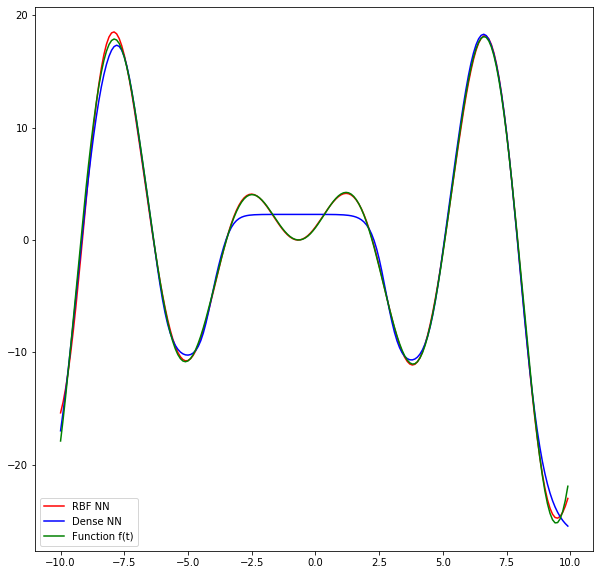

In [20]:
x_real = np.arange(*t_interval)
y_real = np.array([f(value) for value in x_real])

x_real_test = x_real.reshape(len(x_real), 1)
seq_dense_prediction = dense_search.predict(x_real_test)
rbf_prediction = rbf_search.predict(x_real_test)

plt.figure(figsize=(10,10))
plt.plot(x_real, rbf_prediction, color='red', label='RBF NN')
plt.plot(x_real, seq_dense_prediction, color='blue', label='Dense NN')
plt.plot(x_real, y_real, color='green', label='Function f(t)')
plt.legend()
plt.show()

#### Построить графики среднеквадратичной ошибки на этапах обучения и тестирования на одной координатной плоскости для обоих случаев. Сравнить точность на этапах обучения и тестирования для полносвязной и RBF- сетей.


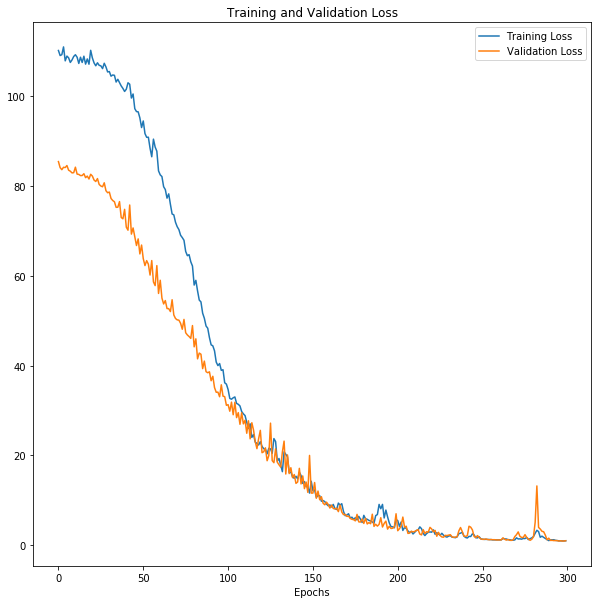

In [21]:
dense_search.best_model_.show_history()

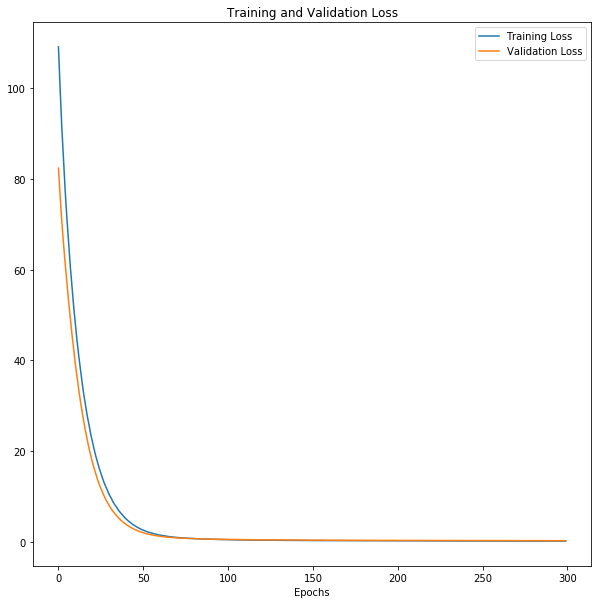

In [22]:
rbf_search.best_model_.show_history()

#### Проанализировать точность аппроксимации в зависимости от количества нейронов во внутреннем слое полносвязной и RBF- сетей на основе построенных графиков функций и среднеквадратичной ошибки.

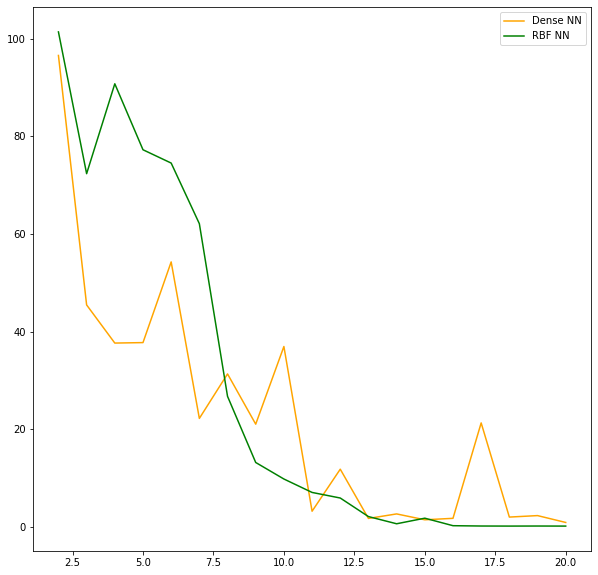

In [23]:
seq_dense_errors = [m.evaluate(x_real, y_real, verbose=0) for m in dense_search.models_history]
rbf_errors = [m.evaluate(x_real, y_real, verbose=0) for m in rbf_search.models_history]
k_values = list(range(2, 2))

plt.figure(figsize=(10,10))
plt.plot(dense_search.params['num_of_neurons'], seq_dense_errors, color='orange', label='Dense NN')
plt.plot(rbf_search.params['num_of_clusters'], rbf_errors, color='green', label='RBF NN')
plt.legend()
plt.show()

Исходя из графиков можно сделать вывод, что RBF сеть справляется со своей задачей лучше: у неё меньше ошибка, график аппроксимируемой функции почти идентичен графику настоящей функции. К тому же она обучается гораздо быстрее, в данном случае за 50 эпох, в том время как полносвязная сеть в 4-5 раз медленнее достигла подобного результата. Точность аппроксимации растёт с увеличением количества нейронов на внутреннем слое в обоих случаях: уже на 12-14 нейронах получаются хорошие результаты.